In [1]:
am_scale = 1

In [2]:
import setup; import matplotlib.pyplot as plt; import numpy as np;
from speech_pause_indicator import speech as original_speech

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [3]:
##https://pyts.readthedocs.io/en/stable/auto_examples/metrics/plot_dtw.html
from pyts.datasets import load_gunpoint; import math
from pyts.metrics import dtw, itakura_parallelogram, sakoe_chiba_band
from pyts.metrics.dtw import (cost_matrix, accumulated_cost_matrix, _return_path, _blurred_path_region)
import itertools; import statistics

In [4]:
# pyts - classic
def classic(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y):
    method = 'classic'
    dtw_classic, path_classic = dtw(x, y, dist='absolute', method=method, return_path=True)
    path = path_classic
    dist = dtw_classic
    alignment_err(x, y, path, file1, file2, seg1_1, seg1_2, seg2_1, seg2_2, time1_lst, time2_lst, xlabel, ylabel, sr, speech_x, speech_y, dist, method)

#     return path, dist

In [5]:
def round_down(num, divisor):
    return num - (num%divisor)

In [6]:
# pyts itakura

def itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech1, speech2):

    method = 'itakura'
    slope = 1.2
    dtw_itakura, path_itakura = dtw(
        x, y, dist='absolute', method='itakura',
        options={'max_slope': slope}, return_path=True
    )
    parallelogram = itakura_parallelogram(n_timestamps_1, n_timestamps_2,
                                          max_slope=slope)
    matrix_itakura = np.zeros((n_timestamps_1 + 1, n_timestamps_2 + 1))
    for i in range(n_timestamps_1):
        matrix_itakura[i, np.arange(*parallelogram[:, i])] = 0.5
    matrix_itakura[tuple(path_itakura)] = 1.
    path = path_itakura
    dist = dtw_itakura
    alignment_err(x, y, path, file1, file2, seg1_1, seg1_2, seg2_1, seg2_2, time1_lst, time2_lst, xlabel, ylabel, sr, speech_x, speech_y, dist, method)    
    
    #return path, dist

In [7]:
# pyts sakoechiba

def sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y):
    method = "sakoechiba"
    window_size = 0.1
    dtw_sakoechiba, path_sakoechiba = dtw(
        x, y, dist='absolute', method='sakoechiba',
        options={'window_size': window_size}, return_path=True
    )
    band = sakoe_chiba_band(n_timestamps_1, n_timestamps_2,
                            window_size=window_size)
    matrix_sakoechiba = np.zeros((n_timestamps_1 + 1, n_timestamps_2 + 1))
    for i in range(n_timestamps_1):
        matrix_sakoechiba[i, np.arange(*band[:, i])] = 0.5
    matrix_sakoechiba[tuple(path_sakoechiba)] = 1.

    path = path_sakoechiba
    dist = dtw_sakoechiba
    alignment_err(x, y, path, file1, file2, seg1_1, seg1_2, seg2_1, seg2_2, time1_lst, time2_lst, xlabel, ylabel, sr, speech_x, speech_y, dist, method)
    
    # return path, dist

In [8]:
def multiscale(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y):
    method = "multiscale"
    x = np.array(x)
    y = np.array(y)
   
    resolution, radius = 5, 2
    dtw_multiscale, path_multiscale = dtw(
        x, y, dist='absolute', method='multiscale',
        options={'resolution': resolution, 'radius': radius}, return_path=True
    )
    
    x = x[0: round_down(len(x), resolution)]
    y = y[0: round_down(len(y), resolution)]

    x_padded = x.reshape(-1, resolution).mean(axis=1)
    y_padded = y.reshape(-1, resolution).mean(axis=1)

    cost_mat_res = cost_matrix(x_padded, y_padded, dist='absolute', region=None)
    acc_cost_mat_res = accumulated_cost_matrix(cost_mat_res)
    path_res = _return_path(acc_cost_mat_res)

    n_timestamps_1 = len(x)
    n_timestamps_2 = len(y)
    
    multiscale_region = _blurred_path_region(
        n_timestamps_1, n_timestamps_2, resolution, x_padded.size, y_padded.size,
        path_res,
        radius=radius
    )    
    
    matrix_multiscale = np.zeros((n_timestamps_1 + 1, n_timestamps_2 + 1))
    
    for i in range(n_timestamps_1):
        matrix_multiscale[i, np.arange(*multiscale_region[:, i])] = 0.5

    path = path_multiscale
    dist = dtw_multiscale
    
    alignment_err(x, y, path, file1, file2, seg1_1, seg1_2, seg2_1, seg2_2, time1_lst, time2_lst, xlabel, ylabel, sr, speech_x, speech_y, dist, method)
     
    # return path, dist

In [9]:
def get_word_xy(smooth_s, smooth_r, time1, seg1_1, seg1_2, time2, seg2_1, seg2_2):
    
    query = smooth_s
    ref = smooth_r
    x = (time1 - seg1_1)/(seg1_2 - seg1_1) * len(query)
    y = (time2 - seg2_1)/(seg2_2 - seg2_1) * len(ref)
    return x, y

# deviation function
def deviation(rho, theta):
    dev = 0
    if rho >= theta and rho <= math.pi/2:
        dev = (rho-theta)/(math.pi/2-theta)
    else:
        dev = (theta - rho)/theta
    return dev

def stretch(path, speech_1, speech_2):
    len_x = max(path[0])
    len_y = max(path[1])
    xs = path[0]
    ys = path[1]
    theta = math.atan(len_y/len_x)    
    numerator = 0
    denominator = 0
    
    stretch_speech = 0
    stretch_pause = 0
    stretch_others = 0
    overall_stretch = 0

    # For 1 point in the warping path x, y
    # xs[i] = index of the point in the original query that dtw uses to align x
    # ys[i] = index of the point in the original reference query that dtw uses to align y                  
    
    # length of path = len(path[0]) = len(path[1])
    for i in range(len(path[0])-1):
        if xs[i+1]-xs[i] == 0:
            rho_i = math.pi/2
        else:
            rho_i = math.atan((ys[i+1]-ys[i]) / (xs[i+1]-xs[i]))

        dev_rho_i = deviation(rho_i, theta)
        numerator = dev_rho_i*math.sqrt((xs[i+1]-xs[i])**2 + (ys[i+1]-ys[i])**2)
        denominator = denominator + math.sqrt((xs[i+1]-xs[i])**2 + (ys[i+1]-ys[i])**2)

        sp1 = speech_1[xs[i]]
        sp2 = speech_2[ys[i]]
        
        if sp1 == sp2 == 1: # Add the deviation to either speech, pause, or not aligned
            stretch_speech = stretch_speech + numerator
        elif sp1 == sp2 == 0:
            stretch_pause = stretch_pause + numerator
        else:
            stretch_others = stretch_others+ numerator
            
    overall_stretch = (stretch_speech + stretch_pause + stretch_others)/denominator
    
    return stretch_speech/denominator, stretch_pause/denominator, stretch_others/denominator, overall_stretch

In [10]:
def downsample(query, ratio):
    # Scale the amplitudes by dividing each amplitude over the largest amplitude magnitude
    max_m = np.abs(max(query))
    res = []
    for i in range(int(len(query) // ratio)):
        if int(i*ratio) < len(query):
            res.append(query[int(i*ratio)]/max_m)
    return res

In [11]:
# Maximum dtw distance = number of points in the alignment path * largest difference between amplitude of x and y

def normalize_distance(x, y, path, dist, method, am_scale = am_scale):
    plt.figure(figsize=(5, 3))
    nor_dist = dist / (am_scale * 2* len(path[0]))
    return nor_dist
    
# unit of distance = amplitude / portion of the alignment path

In [12]:
def make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr, am_scale = am_scale):
    from scipy.io import wavfile 
    capstone_dir = "/Users/ninismacbook/other_docs/Y4S1/capstone" 
    
    file1_path = capstone_dir + "/py_converted/" + file1 ; file2_path = capstone_dir + "/py_converted/" + file2
    
    samplerate, query = wavfile.read(file1_path) ; samplerate, ref = wavfile.read(file2_path)
    ratio = samplerate/sr
    # If input sr = 4410, then ratio = 44100/4410 = 10 (samplerate from py_converted is always 44100)
    
    # Downsample the arrays first
    query_sample = downsample(query, ratio)
    ref_sample = downsample(ref, ratio)
    
    smooth_s = [] # Store smoothened sample array
    smooth_r = [] # Store smoothened ref array
    
    query_s = [] # Store speech indicator for sample array
    ref_s = [] # Store speech indicator for ref array
    
    # Rolling average on query_sample and ref_sample. Store results in smooth_s, smooth_r
    # The fps here is the new fps after downsampling 
    
    frame_per_window = sr * window_len/1000 # Do smoothening on the query and ref
    
    for i in range(len(query_sample)):
        if i < frame_per_window/2:
            i1 = 0 ; i2 = i + int(frame_per_window/2)            
        elif i > (len(query_sample) - frame_per_window/2):
            i1 = i - frame_per_window/2 ; i2 = len(query_sample)
        else:
            i1 = i-frame_per_window/2 ; i2 = i+frame_per_window/2
        num = np.mean(np.abs(query_sample[int(i1) : int(i2)]))
        smooth_s.append(num)
        
    for i in range(len(ref_sample)):
        if i < frame_per_window/2:
            i1 = 0 ; i2 = i + int(frame_per_window/2)            
        elif i > (len(ref_sample) - frame_per_window/2):
            i1 = i - frame_per_window/2 ; i2 = len(ref_sample)
        else:
            i1 = i-frame_per_window/2 ; i2 = i+frame_per_window/2
        num = np.mean(np.abs(ref_sample[int(i1) : int(i2)]))
        smooth_r.append(num)
        
            
    smooth_s = smooth_s[int(sr*seg1_1): int(sr*seg1_2)]
    smooth_r = smooth_r[int(sr*seg2_1): int(sr*seg2_2)]       
        
    query_sample = query[int(sr*seg1_1): int(sr*seg1_2)]
    ref_sample = ref[int(sr*seg2_1): int(sr*seg2_2)]       
    
    # Get speech indicator for the two samples
    query_s = speech(smooth_s, query, seg1_1, seg1_2, samplerate, frame_per_window)
    ref_s = speech(smooth_r, ref, seg2_1, seg2_2, samplerate, frame_per_window)      
    
    # Plot original amplitude graph for first sample
    plot_q = query[int(samplerate*seg1_1): int(samplerate*seg1_2)]
    time1 = np.linspace(seg1_1, seg1_2, num = len(plot_q))    
    plt.figure(figsize=(18.5, 2))    
    plt.plot(time1, plot_q)
    
    # Plot the rolling average and speech indicator function for the first sample
    fig, (ax1, ax2) = plt.subplots(2, 1); fig.set_size_inches(18.5, 2.5)
    length = len(smooth_s) / samplerate
    time1 = np.linspace(seg1_1, seg1_2, num = len(smooth_s))           
    ax1.plot(time1, smooth_s, color = '#A4A4A4')
    ax2.plot(time1, query_s, color = '#A4A4A4');

    # Plot original amplitude graph for second sample
    plot_r = ref[int(samplerate*seg2_1): int(samplerate*seg2_2)]
    time2 = np.linspace(seg2_1, seg2_2, num = len(plot_r))
    plt.figure(figsize=(18.5, 2))
    plt.plot(time2, plot_r)
    
    # Plot the rolling average and speech indicator function for the second sample    
    fig, (ax1, ax2) = plt.subplots(2, 1); fig.set_size_inches(18.5, 2.5)
    time2 = np.linspace(seg2_1, seg2_2, num = len(smooth_r))
    ax1.plot(time2, smooth_r, color = '#A4A4A4')
    ax2.plot(time2, ref_s, color = '#A4A4A4');    
    
    return plot_q, plot_r, sr, smooth_s, smooth_r, query_s, ref_s

In [13]:
def plot_all():
    classic(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)
#     itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)
#     sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)
#     multiscale(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

In [14]:
def alignment_err(x, y, path, file1, file2, seg1_1, seg1_2, seg2_1, seg2_2, time1_lst, time2_lst, xlabel, ylabel, sr, speech1, speech2, dist, method):
    nor_dist = normalize_distance(x, y, path, dist, method)
    colors = ['red', 'g', 'b', 'm', 'brown', '#d89743', 'grey', 'c', 'orange', 'g', 'b', 'm', 'red']
    err = []
    for i in range(len(time1_lst)):
        x_axis, y_axis = get_word_xy(x, y, time1_lst[i], seg1_1, seg1_2, time2_lst[i], seg2_1, seg2_2)
        
        plt.scatter(x_axis, y_axis, color = colors[i], marker = "X", edgecolor = 'black', s = 100)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        
        x_val = list(itertools.chain(*np.where(np.abs(path[0] - x_axis) < 1)))[0]
        y_val = list(itertools.chain(*np.where(np.abs(path[1] - y_axis) < 1)))[0]

        warp_y = path[1][x_val]
        warp_x = path[0][y_val]
        
        e = (np.abs(warp_x - x_axis) + np.abs(warp_y - y_axis))/sr
        err.append(e)    # unit = second
        
    median = statistics.median(err)
    err_sum = sum(err)
    
    plt.title('dtw %s distance: %.10f' %(method, nor_dist));    
    plt.plot(path[0], path[1]);    
    
    text1 = 'Avg err (s): %.3f. \nMedian err (s): %.3f' %(err_sum/len(time1_lst), median)
    text2 = '\nStretch speech: %.3f \nStretch pause: %.3f. \nStretch unaligned: %.3f. \nStretch overall: %.3f.' %stretch(path, speech1, speech2)    

    # print text
    plt.text(max(path[0])*1.4, 0, text1+text2, fontsize=14)
    plt.grid(True)
    plt.subplots_adjust(right = 1)

In [15]:
def speech(smooth_query, original_query, seg1_1, seg1_2, samplerate, frame_per_window, am_scale = am_scale):
    
    # Take the amplitudes in the 30 ms as the window. Find upper and lower bound
    # Avoid the immediate ms in the beginning of the query because some devices have start sound
    abs_q = np.abs(original_query[int(samplerate*0.5): int(samplerate*0.5 + frame_per_window)])
    
    max_am = max(np.abs(original_query))
    smooth_s = []
    abs_q_len = len(abs_q)
    
    # Upper and lower bound of the filter: absolute value of amplitude. Upper and lower refers to the silent amplitude
    upper = np.max(abs_q)
    lower = np.min(abs_q)
    
    result = []                
    for i in range(len(smooth_query)):
        
        # Since we scaled the amplitudes, we need to multiple the smoothened amplitude value by the normalization constant
        if np.abs(smooth_query[i]*max_am) > upper :
            result.append(1)
        else:
            result.append(0)
                
    return result

# 4000 fps, 40 ms window

In [16]:
window_len = 40 # Unit: ms
sr = 4000
play_sr = 44100

# Normal v.s. Normal 01 vs. 01_1 Bamboo walls are getting to be very popular

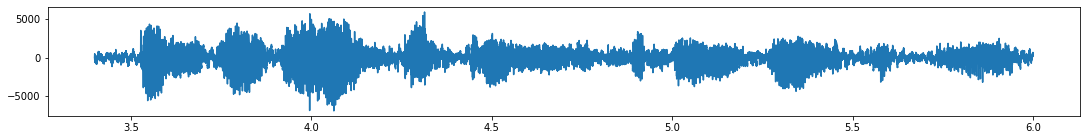

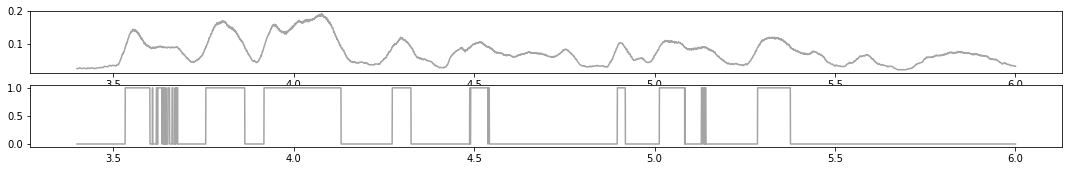

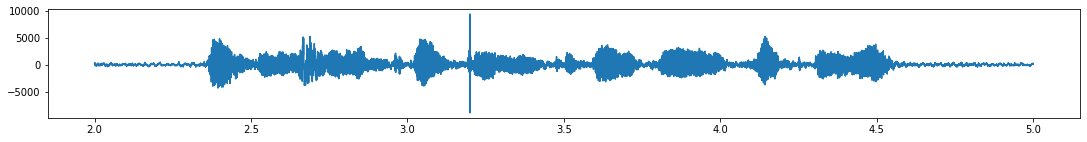

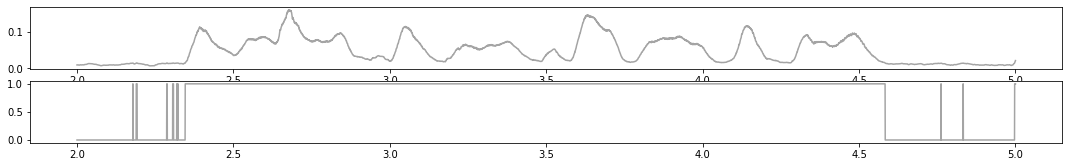

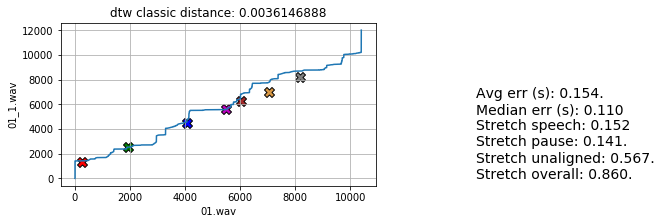

In [18]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "01_1.wav", 2, 5
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [3.46, 3.88, 4.42, 4.77, 4.91, 5.16, 5.44]
time2_lst = [2.33, 2.63, 3.12, 3.4, 3.57, 3.74, 4.06]

xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
plot_all();

# Normal v.s. Normal 01 vs. 01_2

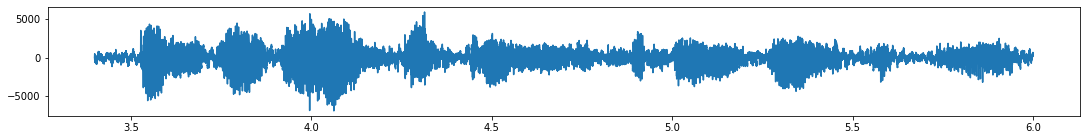

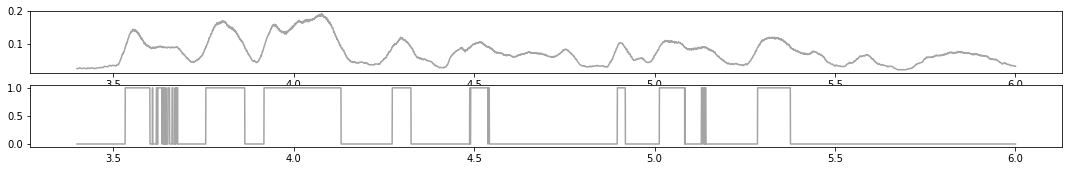

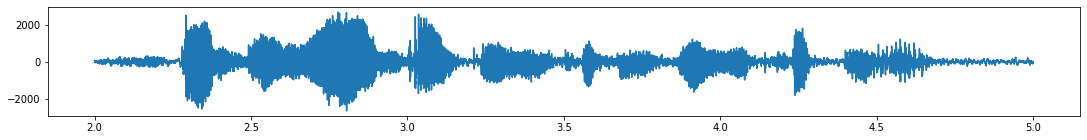

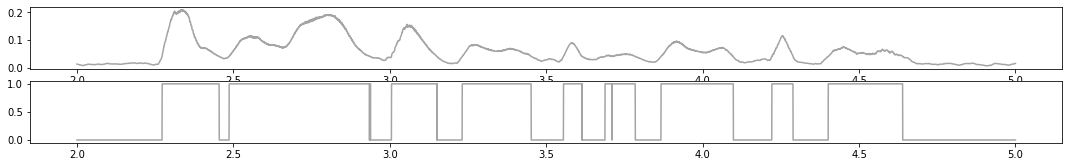

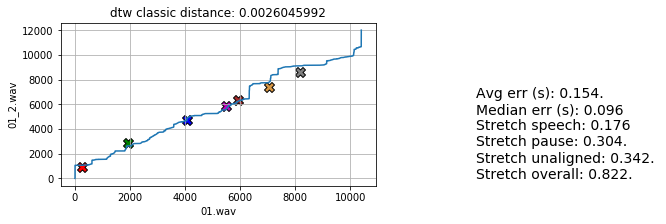

In [19]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "01_2.wav", 2, 5
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [3.46, 3.88, 4.42, 4.77, 4.88, 5.16, 5.44] ;
time2_lst = [2.24, 2.72, 3.18, 3.46, 3.59, 3.84, 4.16]

xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
plot_all();

# Normal v.s. Normal 01 vs. 01_3

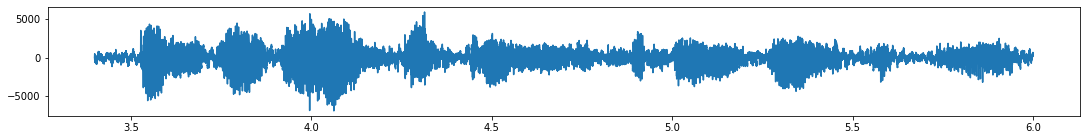

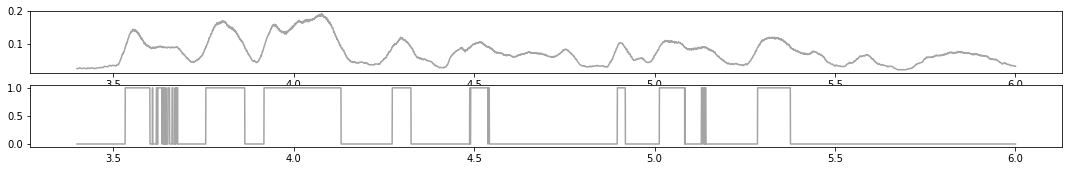

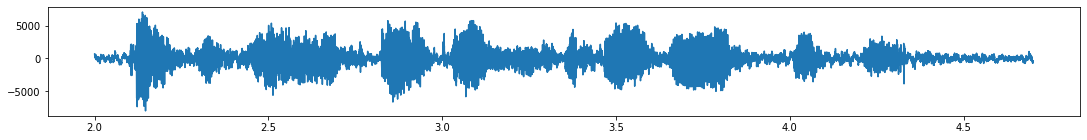

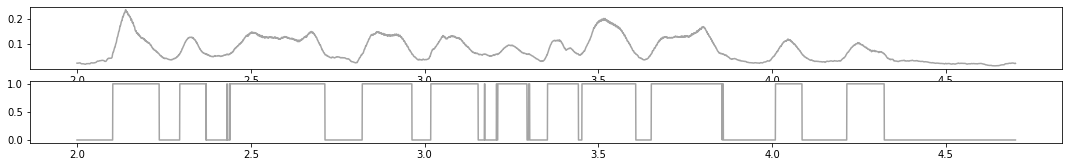

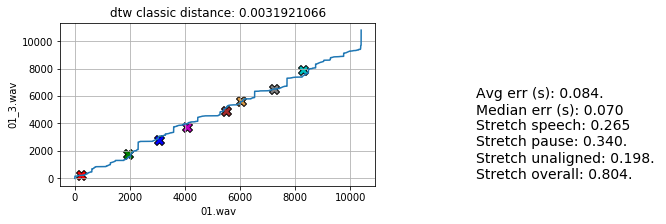

In [20]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4.7
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)

time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] ;
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
plot_all();

# Normal v.s. Normal 01_1 vs. 01_3

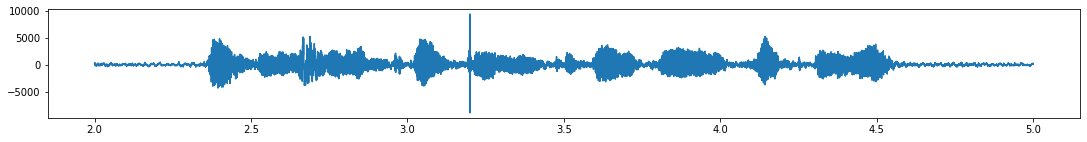

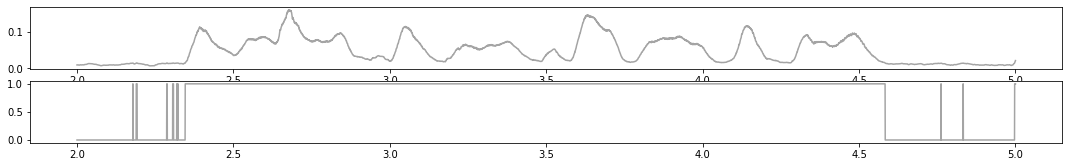

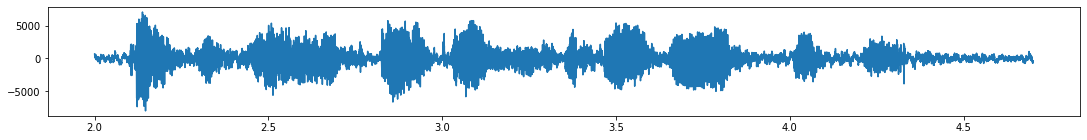

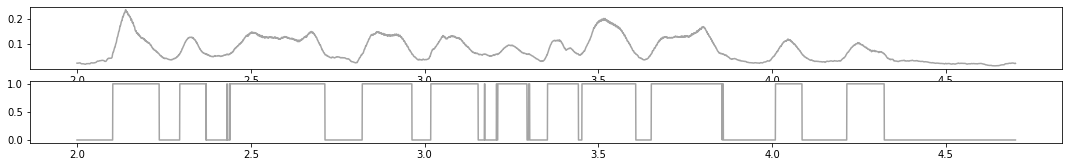

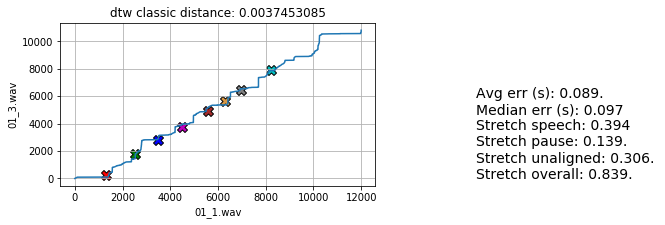

In [21]:
file1, seg1_1, seg1_2 = "01_1.wav", 2, 5
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4.7
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [2.33, 2.63, 2.87, 3.12, 3.4, 3.57, 3.74, 4.06]
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
plot_all();

# Normal v.s. Normal 01_2 vs. 01_3

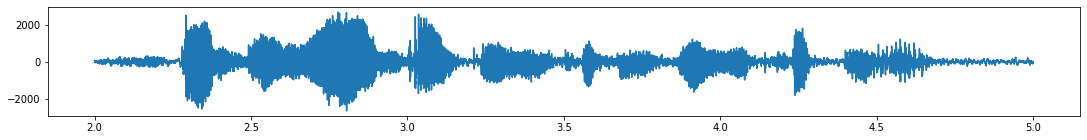

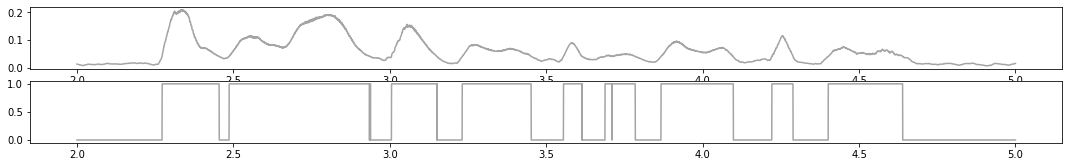

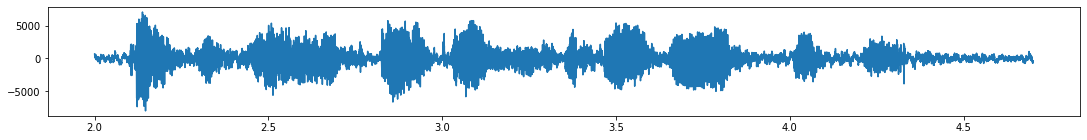

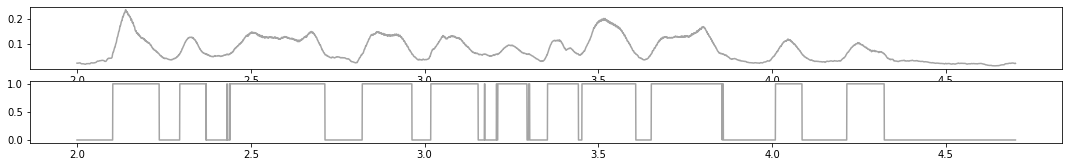

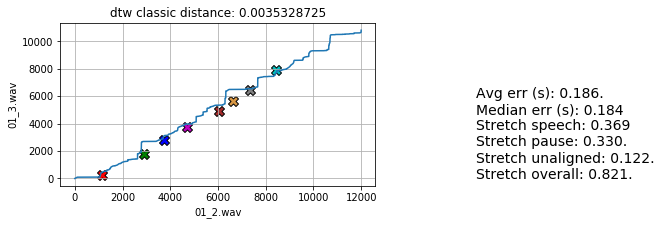

In [22]:
file1, seg1_1, seg1_2 = "01_2.wav", 2, 5
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4.7
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)

time1_lst = [2.28, 2.72, 2.93, 3.18, 3.51, 3.66, 3.84, 4.11]
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
plot_all();

# Normal v.s. Normal 01_1 vs. 01_2

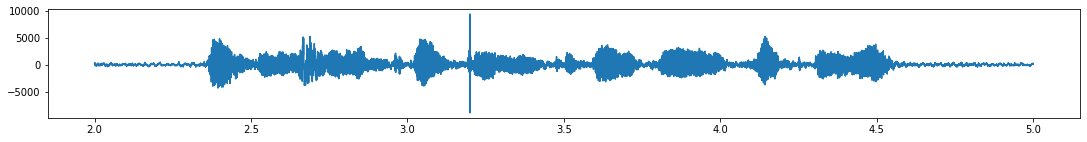

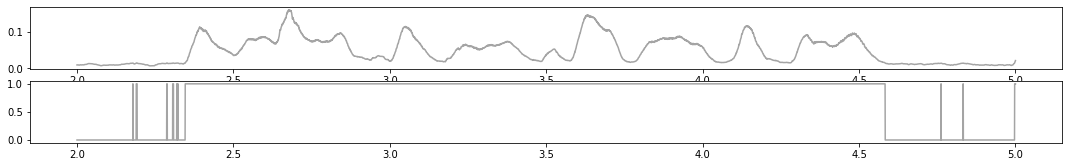

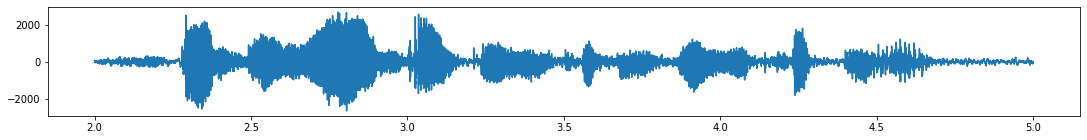

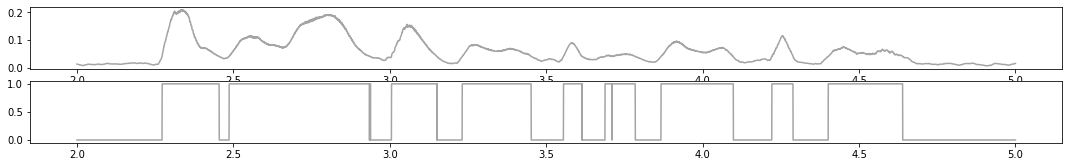

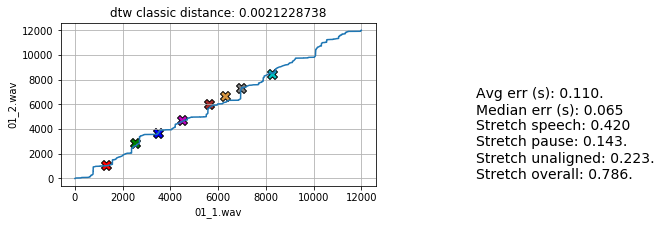

In [23]:
file1, seg1_1, seg1_2 = "01_1.wav", 2, 5
file2, seg2_1, seg2_2 = "01_2.wav", 2, 5
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [2.33, 2.63, 2.87, 3.12, 3.4, 3.57, 3.74, 4.06]
time2_lst = [2.28, 2.72, 2.93, 3.18, 3.51, 3.66, 3.84, 4.11]


xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
plot_all();

# 8000 fps, 40 ms window

In [24]:
window_len = 40 # Unit: ms
sr = 8000
play_sr = 44100

# Normal v.s. Normal 01 vs. 01_1 Bamboo walls are getting to be very popular

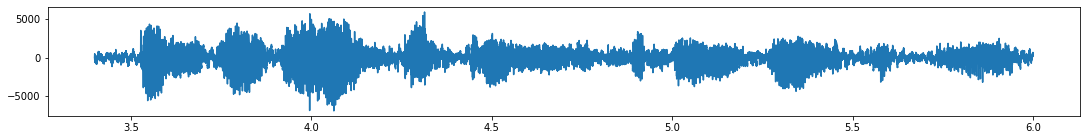

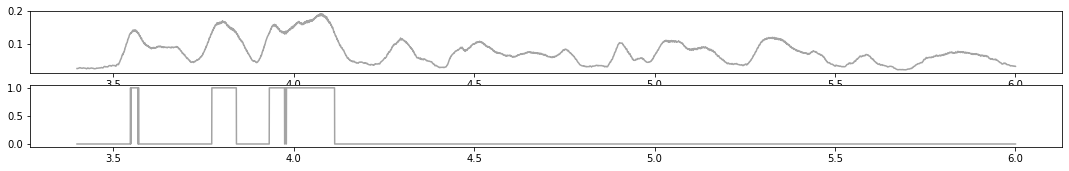

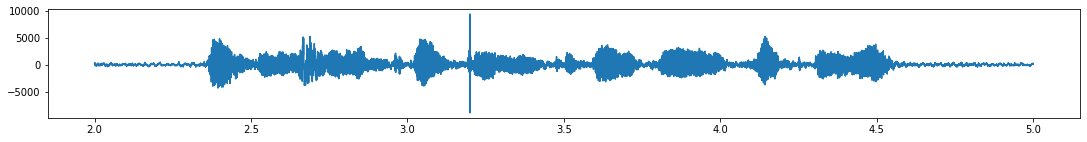

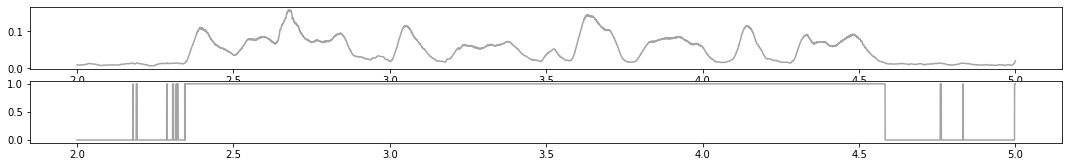

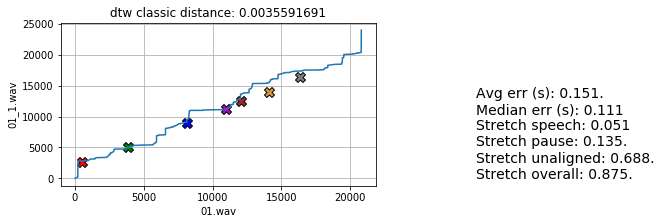

In [25]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "01_1.wav", 2, 5
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [3.46, 3.88, 4.42, 4.77, 4.91, 5.16, 5.44]
time2_lst = [2.33, 2.63, 3.12, 3.4, 3.57, 3.74, 4.06]

xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
plot_all();

# Normal v.s. Normal 01 vs. 01_2

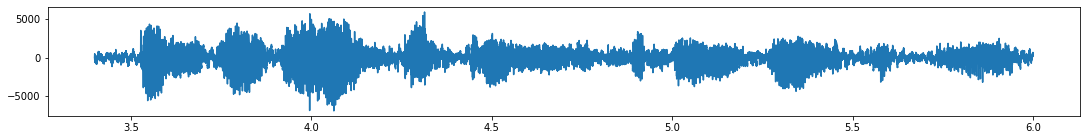

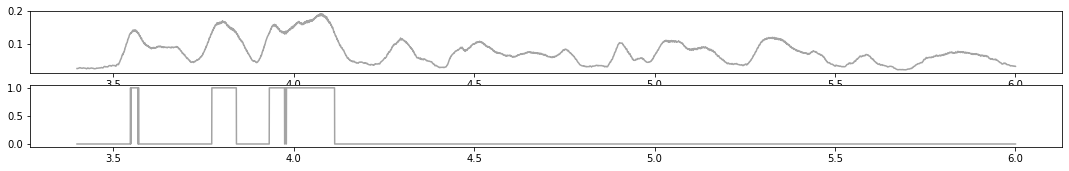

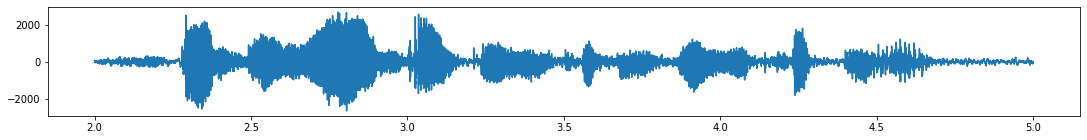

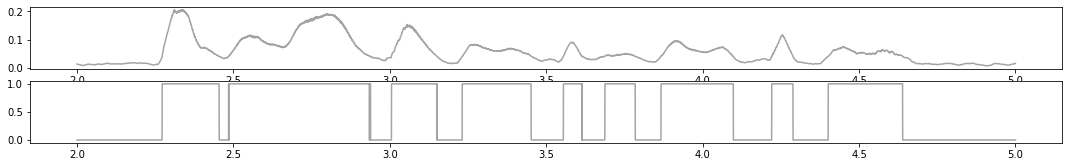

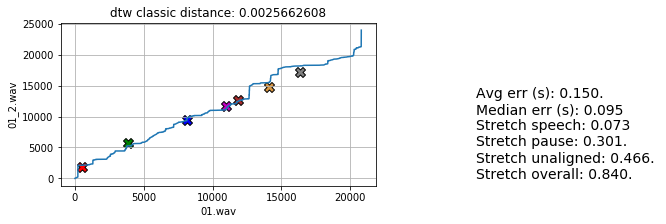

In [26]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "01_2.wav", 2, 5
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [3.46, 3.88, 4.42, 4.77, 4.88, 5.16, 5.44] ;
time2_lst = [2.24, 2.72, 3.18, 3.46, 3.59, 3.84, 4.16]

xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
plot_all();

# Normal v.s. Normal 01 vs. 01_3

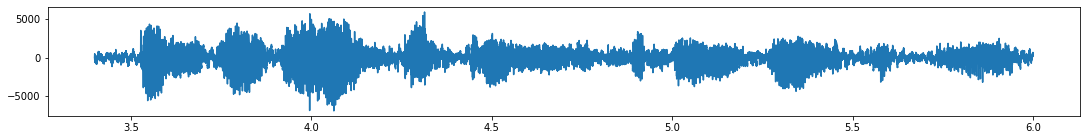

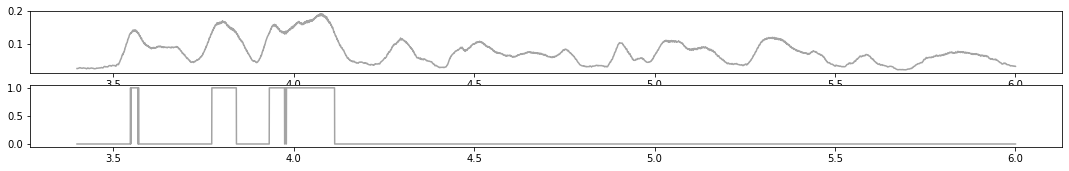

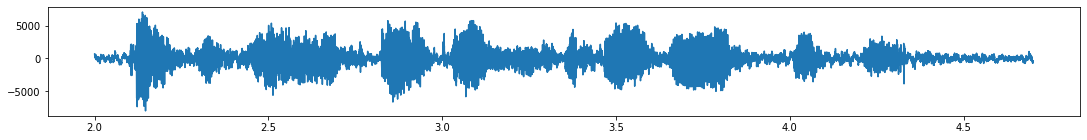

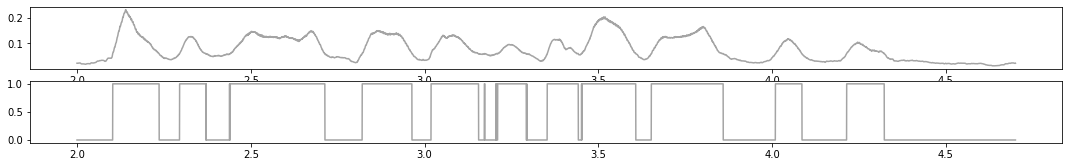

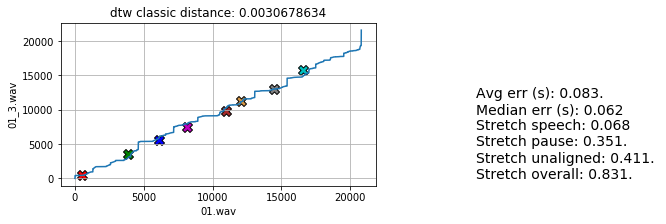

In [27]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4.7
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)

time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] ;
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
plot_all();

# Normal v.s. Normal 01_1 vs. 01_3

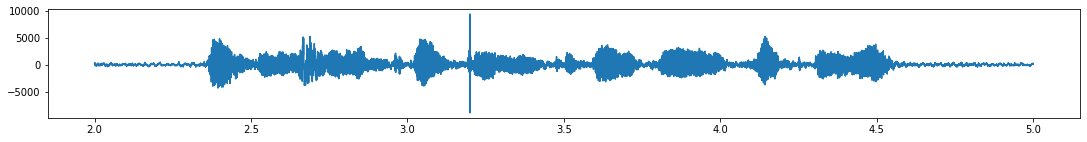

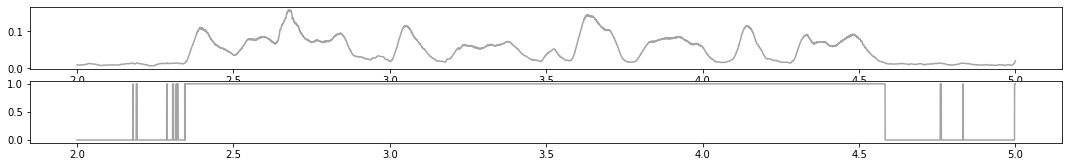

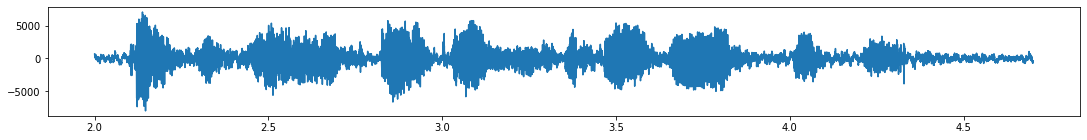

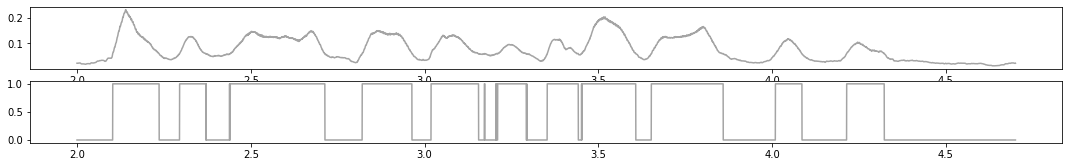

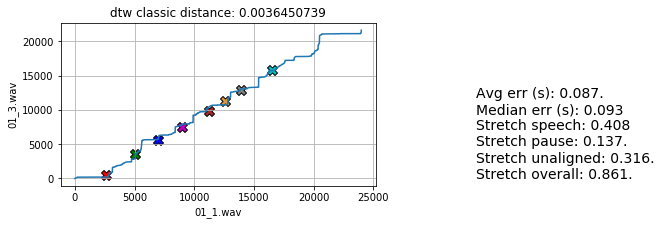

In [28]:
file1, seg1_1, seg1_2 = "01_1.wav", 2, 5
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4.7
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [2.33, 2.63, 2.87, 3.12, 3.4, 3.57, 3.74, 4.06]
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
plot_all();

# Normal v.s. Normal 01_2 vs. 01_3

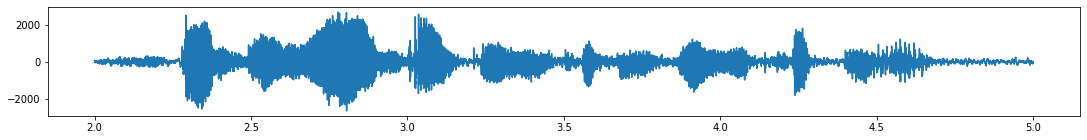

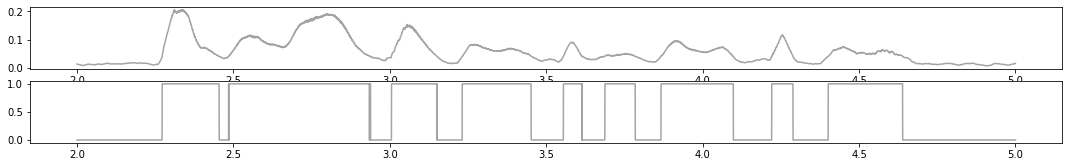

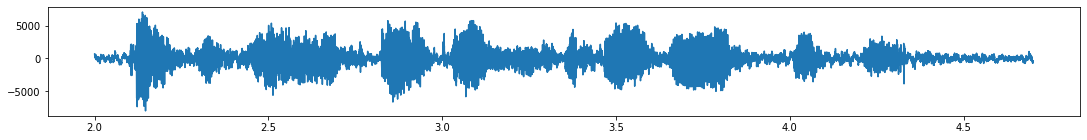

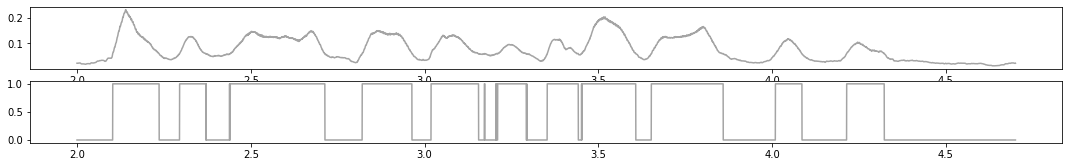

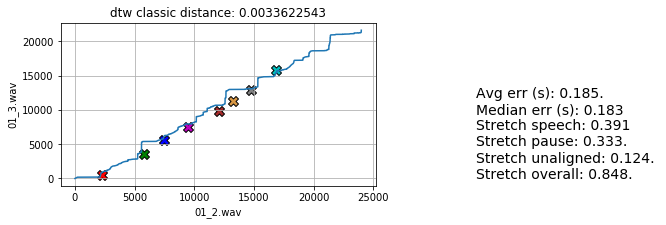

In [29]:
file1, seg1_1, seg1_2 = "01_2.wav", 2, 5
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4.7
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)

time1_lst = [2.28, 2.72, 2.93, 3.18, 3.51, 3.66, 3.84, 4.11]
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
plot_all();

# Normal v.s. Normal 01_1 vs. 01_2

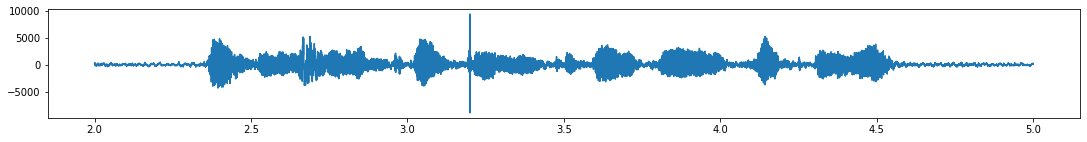

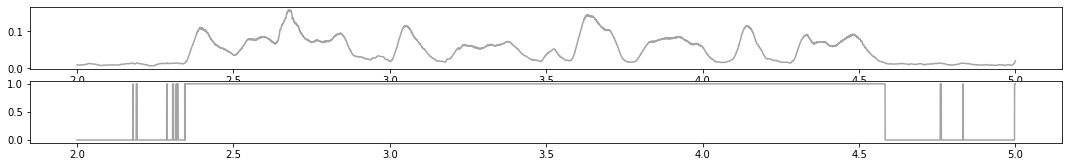

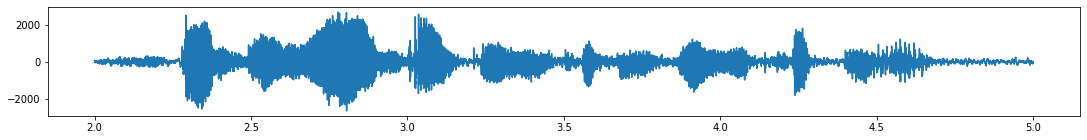

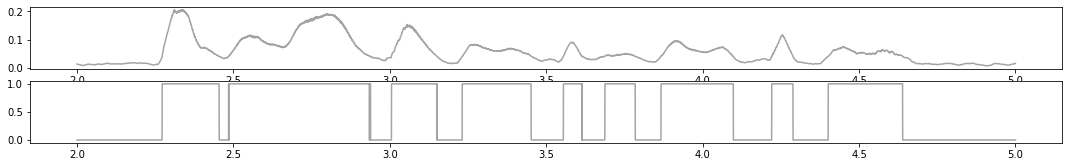

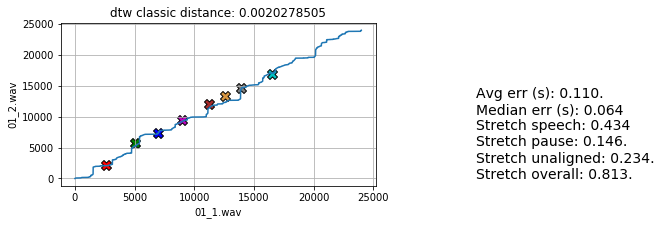

In [30]:
file1, seg1_1, seg1_2 = "01_1.wav", 2, 5
file2, seg2_1, seg2_2 = "01_2.wav", 2, 5
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [2.33, 2.63, 2.87, 3.12, 3.4, 3.57, 3.74, 4.06]
time2_lst = [2.28, 2.72, 2.93, 3.18, 3.51, 3.66, 3.84, 4.11]


xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
plot_all();

# 2000 fps, 40 ms window

In [31]:
window_len = 40 # Unit: ms
sr = 2000
play_sr = 44100

# Normal v.s. Normal 01 vs. 01_1 Bamboo walls are getting to be very popular

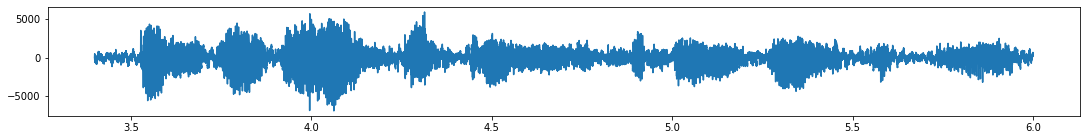

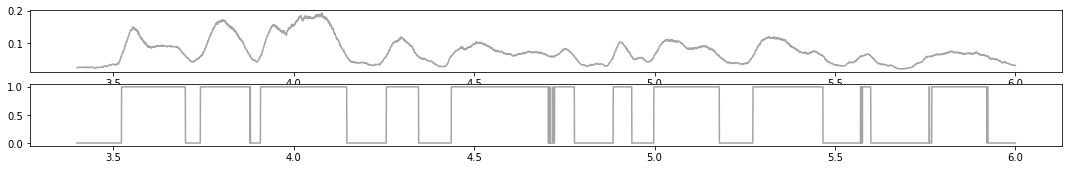

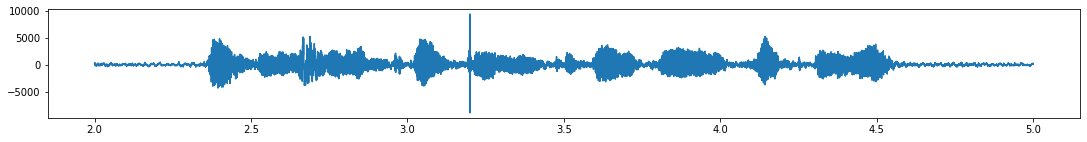

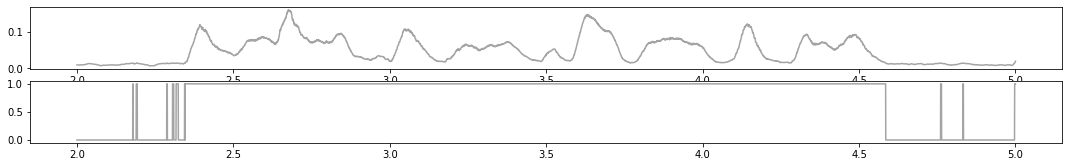

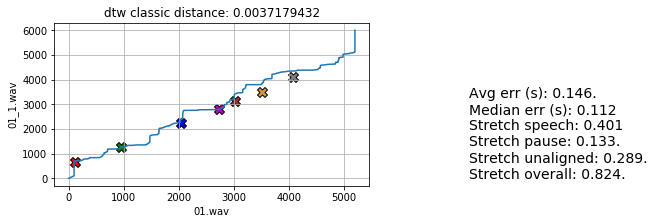

In [32]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "01_1.wav", 2, 5
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [3.46, 3.88, 4.42, 4.77, 4.91, 5.16, 5.44]
time2_lst = [2.33, 2.63, 3.12, 3.4, 3.57, 3.74, 4.06]

xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
plot_all();

# Normal v.s. Normal 01 vs. 01_2

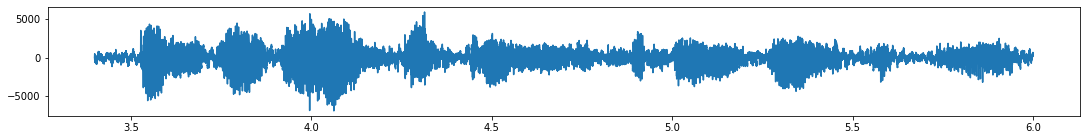

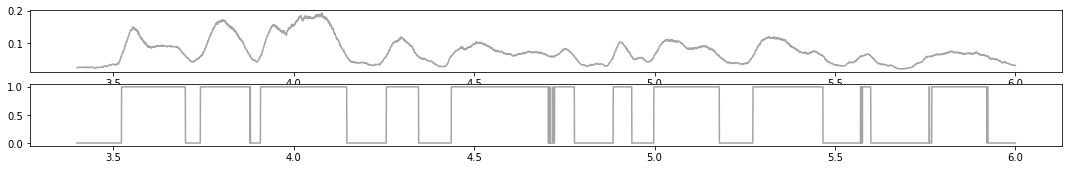

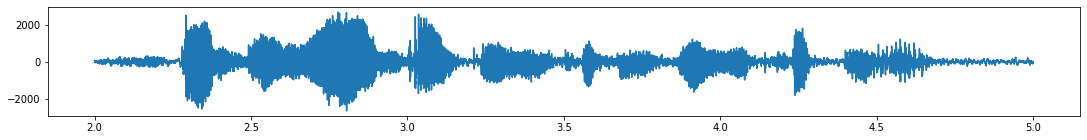

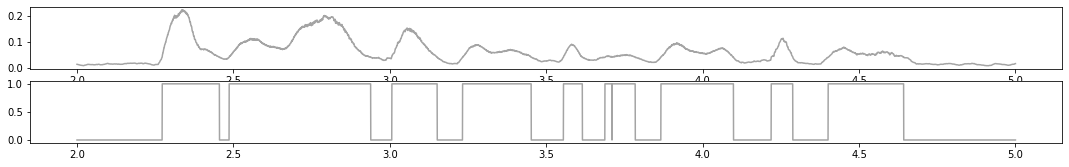

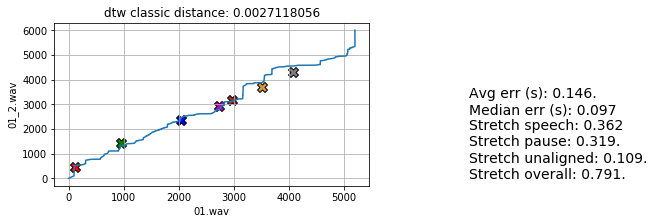

In [33]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "01_2.wav", 2, 5
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [3.46, 3.88, 4.42, 4.77, 4.88, 5.16, 5.44] ;
time2_lst = [2.24, 2.72, 3.18, 3.46, 3.59, 3.84, 4.16]

xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
plot_all();

# Normal v.s. Normal 01 vs. 01_3

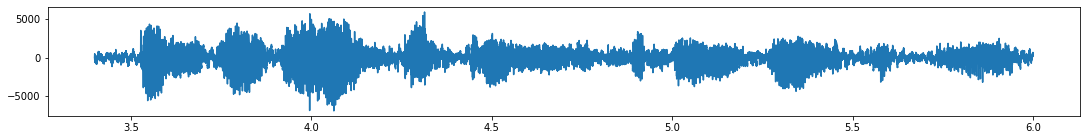

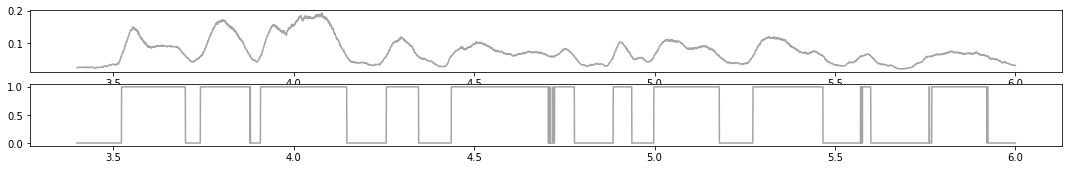

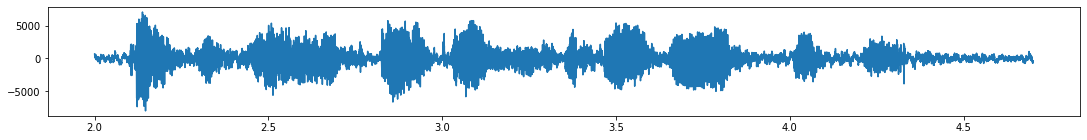

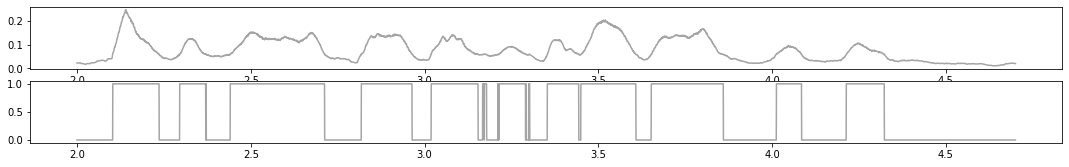

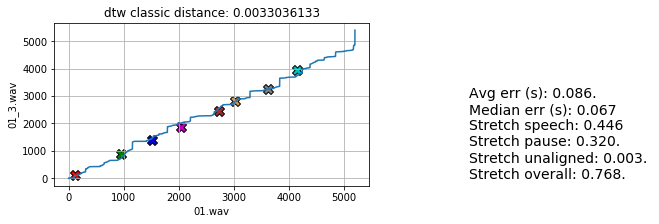

In [34]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4.7
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)

time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] ;
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
plot_all();

# Normal v.s. Normal 01_1 vs. 01_3

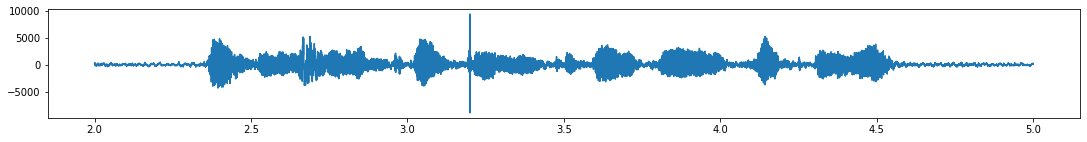

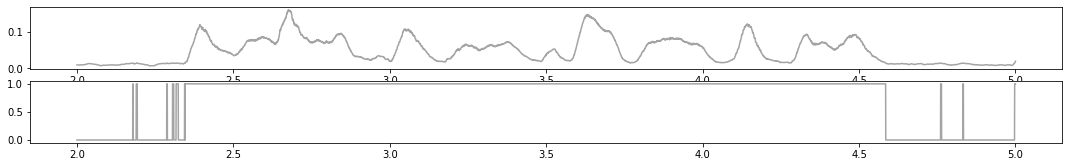

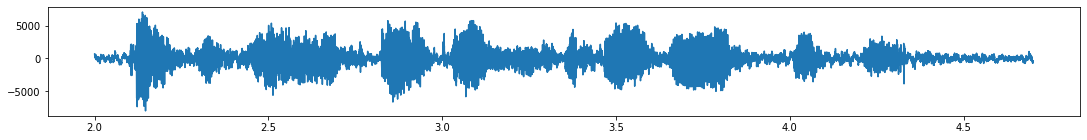

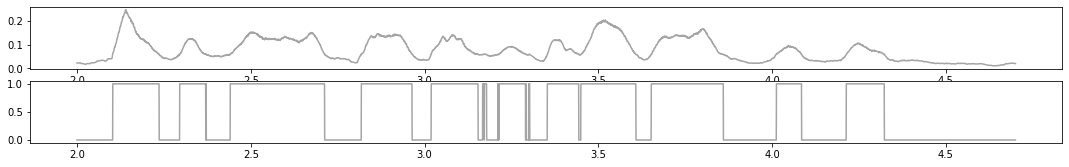

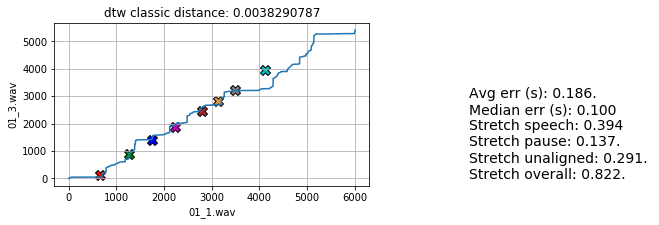

In [35]:
file1, seg1_1, seg1_2 = "01_1.wav", 2, 5
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4.7
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [2.33, 2.63, 2.87, 3.12, 3.4, 3.57, 3.74, 4.06]
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
plot_all();

# Normal v.s. Normal 01_2 vs. 01_3

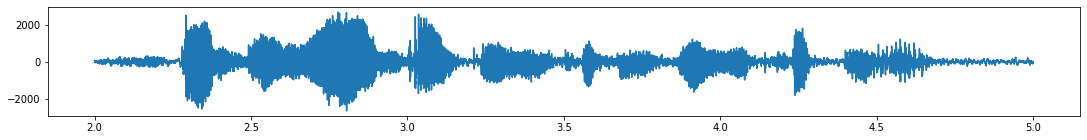

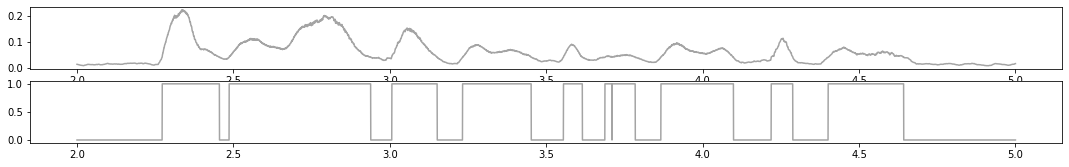

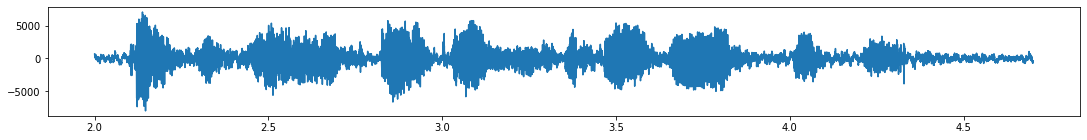

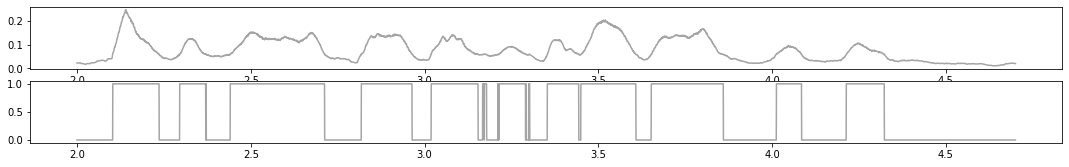

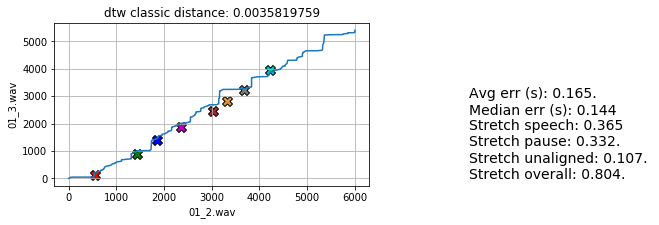

In [36]:
file1, seg1_1, seg1_2 = "01_2.wav", 2, 5
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4.7
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)

time1_lst = [2.28, 2.72, 2.93, 3.18, 3.51, 3.66, 3.84, 4.11]
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
plot_all();

# Normal v.s. Normal 01_1 vs. 01_2

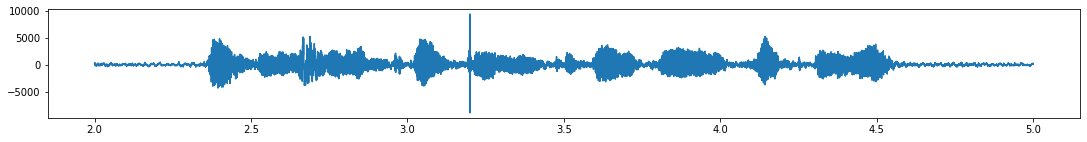

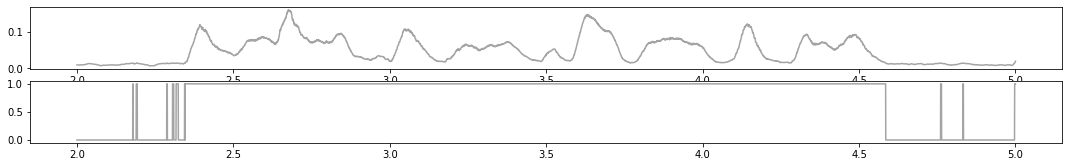

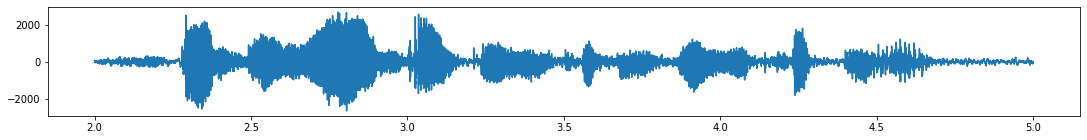

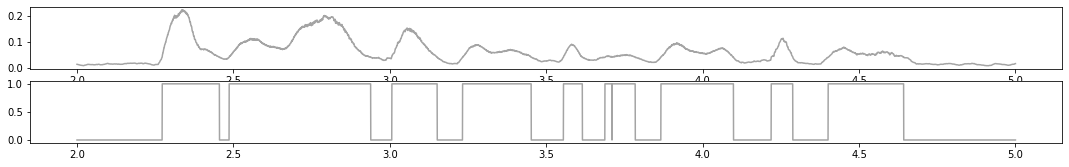

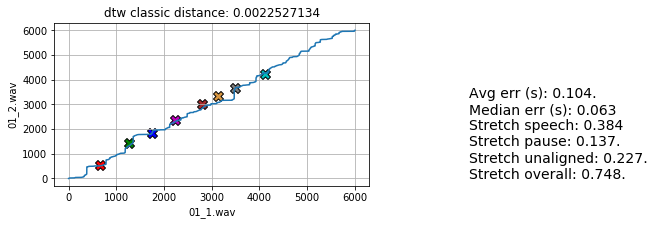

In [37]:
file1, seg1_1, seg1_2 = "01_1.wav", 2, 5
file2, seg2_1, seg2_2 = "01_2.wav", 2, 5
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [2.33, 2.63, 2.87, 3.12, 3.4, 3.57, 3.74, 4.06]
time2_lst = [2.28, 2.72, 2.93, 3.18, 3.51, 3.66, 3.84, 4.11]


xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
plot_all();

# 1000 fps, 40 ms window

In [38]:
window_len = 40 # Unit: ms
sr = 1000
play_sr = 44100

# Normal v.s. Normal 01 vs. 01_1 Bamboo walls are getting to be very popular

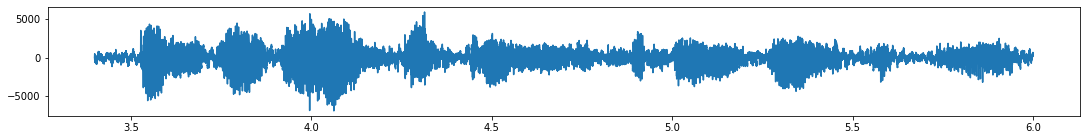

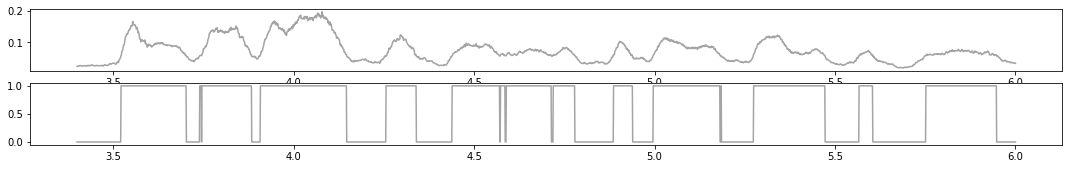

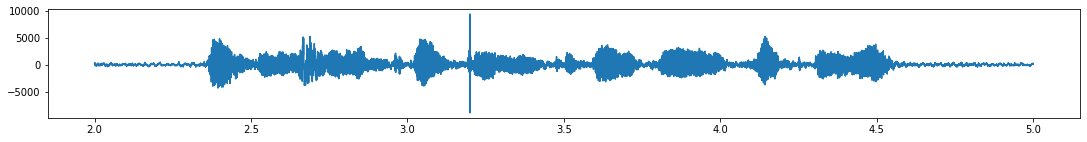

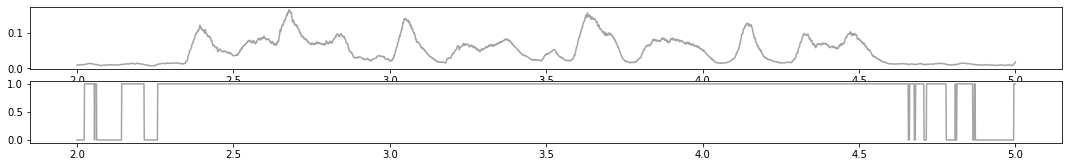

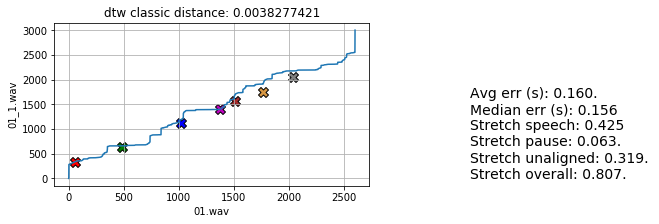

In [39]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "01_1.wav", 2, 5
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [3.46, 3.88, 4.42, 4.77, 4.91, 5.16, 5.44]
time2_lst = [2.33, 2.63, 3.12, 3.4, 3.57, 3.74, 4.06]

xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
plot_all();

# Normal v.s. Normal 01 vs. 01_2

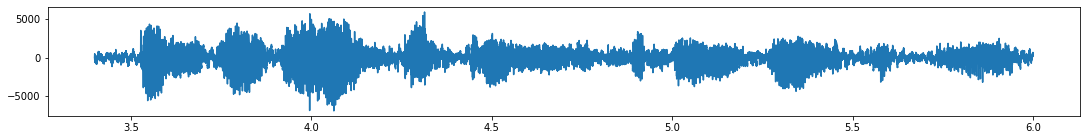

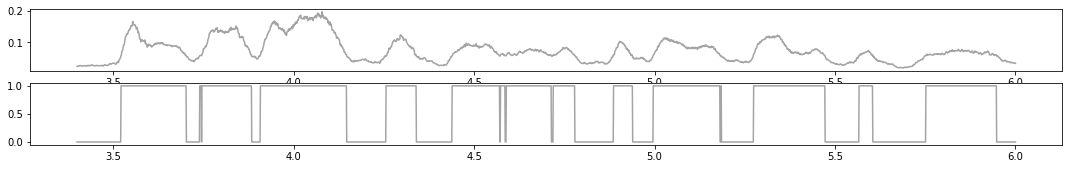

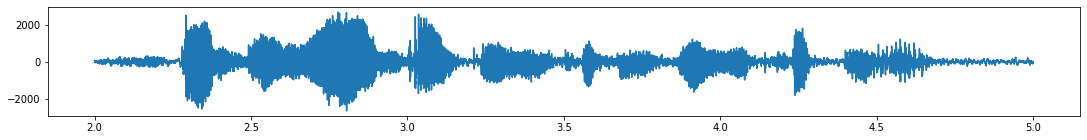

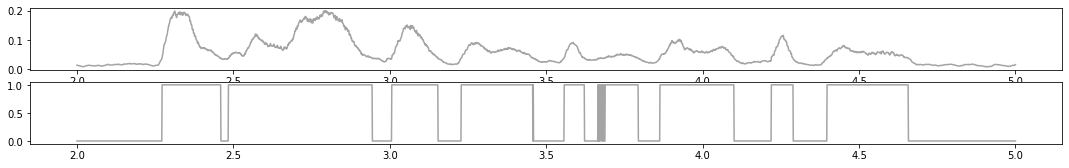

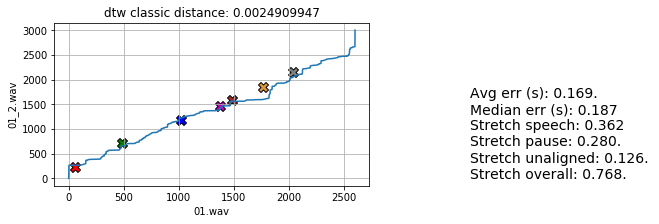

In [40]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "01_2.wav", 2, 5
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [3.46, 3.88, 4.42, 4.77, 4.88, 5.16, 5.44] ;
time2_lst = [2.24, 2.72, 3.18, 3.46, 3.59, 3.84, 4.16]

xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
plot_all();

# Normal v.s. Normal 01 vs. 01_3

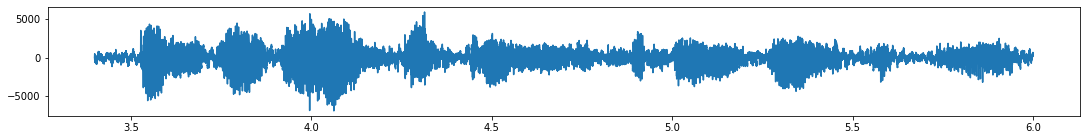

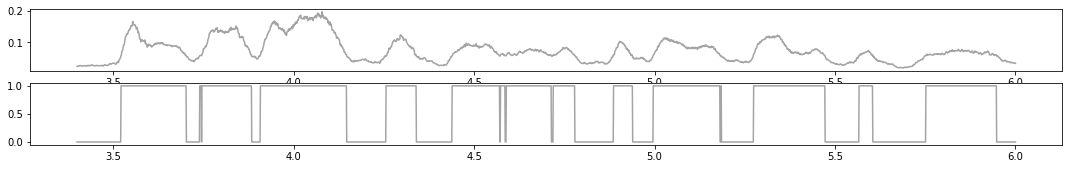

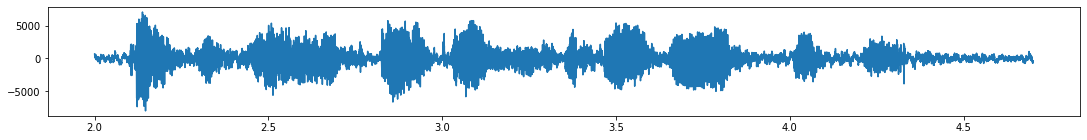

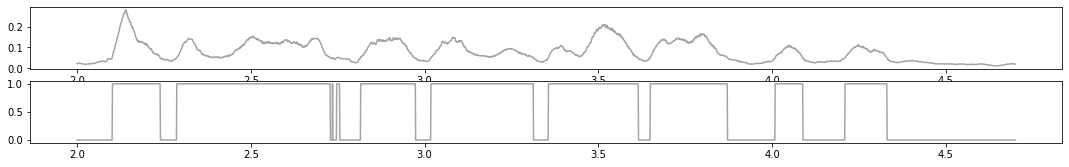

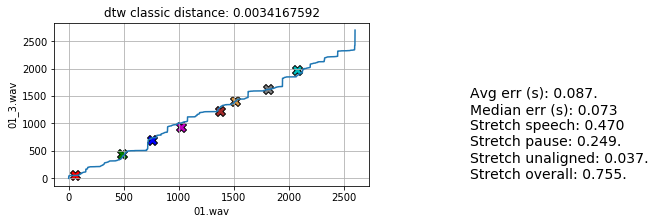

In [41]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4.7
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)

time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] ;
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
plot_all();

# Normal v.s. Normal 01_1 vs. 01_3

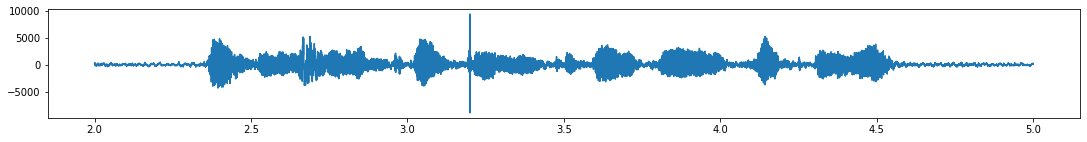

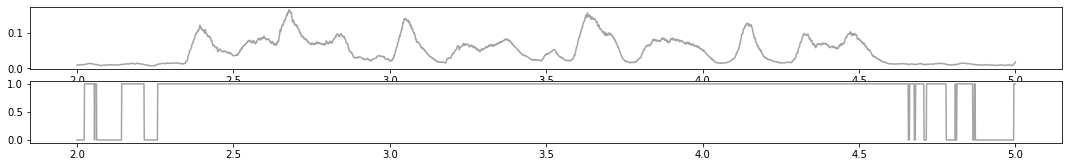

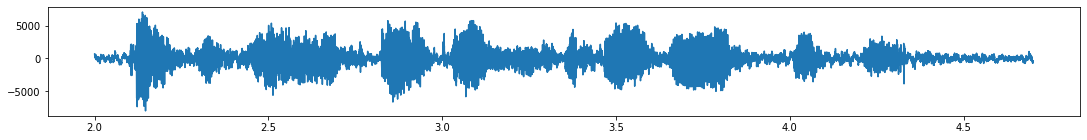

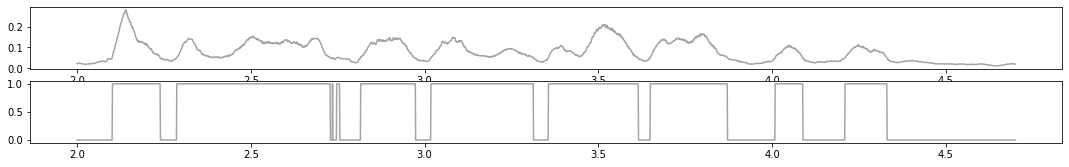

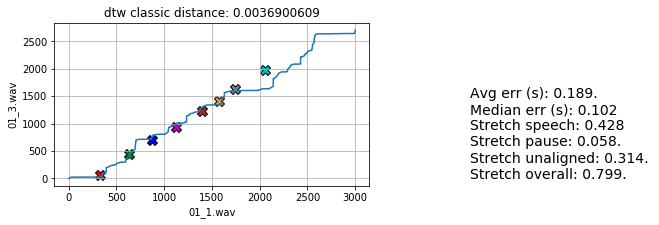

In [42]:
file1, seg1_1, seg1_2 = "01_1.wav", 2, 5
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4.7
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [2.33, 2.63, 2.87, 3.12, 3.4, 3.57, 3.74, 4.06]
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
plot_all();

# Normal v.s. Normal 01_2 vs. 01_3

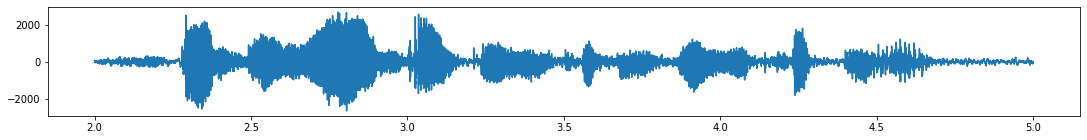

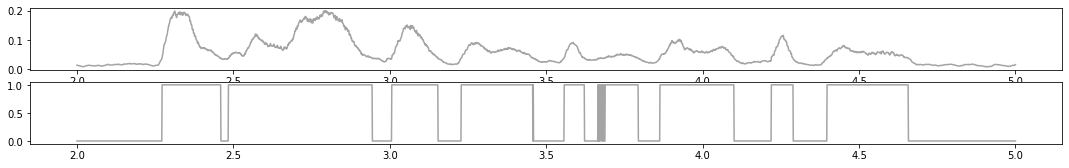

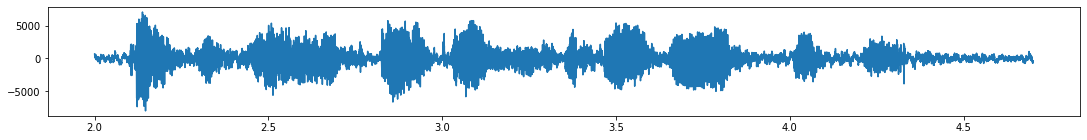

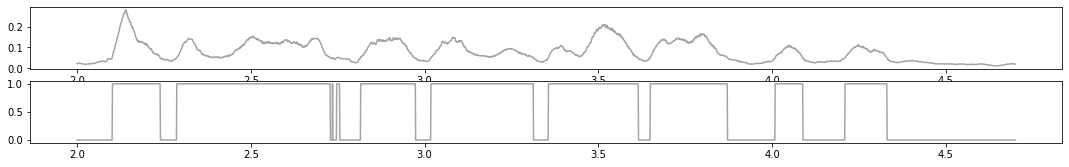

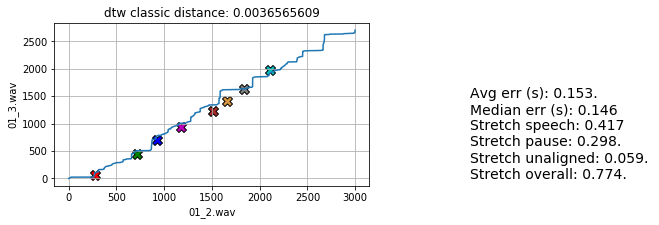

In [43]:
file1, seg1_1, seg1_2 = "01_2.wav", 2, 5
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4.7
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)

time1_lst = [2.28, 2.72, 2.93, 3.18, 3.51, 3.66, 3.84, 4.11]
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
plot_all();

# Normal v.s. Normal 01_1 vs. 01_2

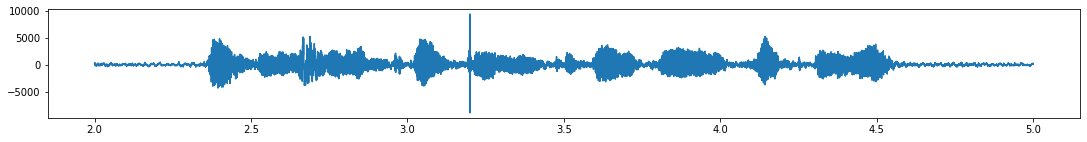

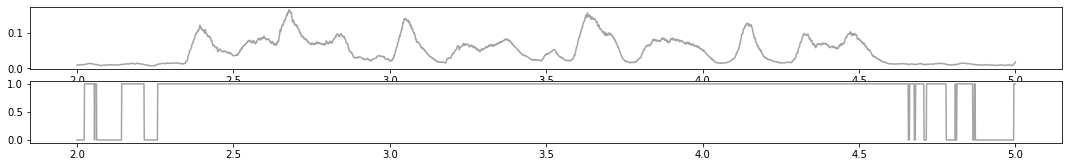

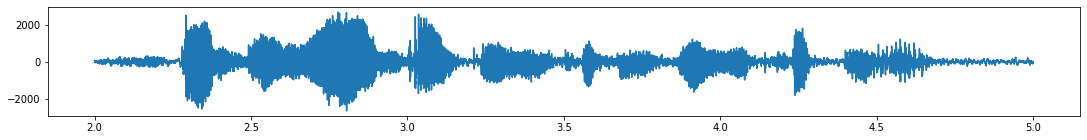

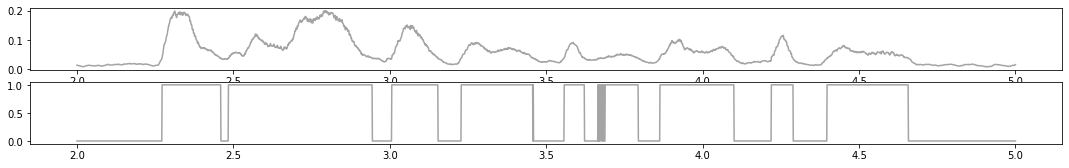

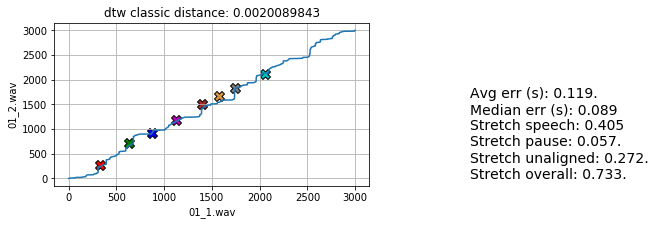

In [44]:
file1, seg1_1, seg1_2 = "01_1.wav", 2, 5
file2, seg2_1, seg2_2 = "01_2.wav", 2, 5
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [2.33, 2.63, 2.87, 3.12, 3.4, 3.57, 3.74, 4.06]
time2_lst = [2.28, 2.72, 2.93, 3.18, 3.51, 3.66, 3.84, 4.11]


xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
plot_all();